In [28]:
import time
import math
import zlib
import hashlib


In [29]:
#!/usr/bin/env python3
"""
This module defines:
  - The IWT class that implements an Integer Wavelet Transform (IWT) based steganography technique.
  - Methods to encode secret messages into images by partitioning the image into 8x8 blocks, applying the IWT,
    modifying selected subband coefficients to embed secret bits, and reconstructing the image.
  - Methods to decode hidden messages from stego-images by reversing the IWT process and extracting the embedded bits.
  - Helper functions to perform image padding, block reconstruction, and bit-level conversions to support the encoding and decoding processes.
  - Integration with various libraries (e.g., OpenCV, NumPy, and Crypto modules) for image processing, encryption, and randomness,
    ensuring robust and secure steganography operations.
"""


import cv2
import numpy as np
from Crypto.Cipher import AES
import pq_ntru
import cv2
import base64
import time
import matplotlib.pyplot as plt
import CHAOSDCGAN as cdc
import torch
import secrets
import IWT_FAST
import base64
from Crypto.Cipher import AES
import time
import cv2
from datetime import datetime 
import CloudQRHandler as cloudthing

credentials_path = "/teamspace/studios/this_studio/project_dir/logical-factor-455520-m8-2405e5b6a50c.json"
bucket_name = "dctimages"
# Create a CloudQRHandler object
cloud_handler = cloudthing.CloudQRHandler(credentials_path, bucket_name)

# ---------------------------
# Global Configuration
# ---------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_DIM = 1024
BATCH_SIZE = 32
MODEL_PATH_G = "/teamspace/studios/this_studio/expanded_generator_dcgan_9CHAN_GPT.pth"
# Tolerance for smart randomisation (mode frequency must be within ±20% of average)
TOLERANCE = 0.45




gan_bytes_all = cdc.inference()




import secrets
import base64
from Crypto.Cipher import AES
import numpy as np
from numba import njit

# AES Encryption (returns a single string)
def encrypt_message(plaintext, aes_key=None):
    if aes_key is None:
        assert len(gan_bytes_all) >= 32, "Not enough bytes to select from."
        # Securely select 32 random indices from gan_bytes_all using a CSPRNG
        random_indices = secrets.SystemRandom().sample(range(len(gan_bytes_all)), 32)
        # Extract the randomly chosen bytes and convert to a bytes object using list comprehension
        # Explicitly build a list to guarantee 32 bytes
        key_list = []
        for i in random_indices:
            key_list.append(gan_bytes_all[i])
        aes_key = bytes(key_list)        
    # Securely select 12 random bytes for the IV (recommended length for AES-GCM)
    iv_random_indices = secrets.SystemRandom().sample(range(len(gan_bytes_all)), 12)
    iv_list = []
    for i in iv_random_indices:
        iv_list.append(gan_bytes_all[i])
    iv = bytes(iv_list)
    # AES-GCM recommended IV length
    cipher = AES.new(aes_key, AES.MODE_GCM, nonce=iv)
    ciphertext, tag = cipher.encrypt_and_digest(plaintext.encode('utf-8'))

    # Convert everything to a single string
    encrypted_string = (
        aes_key.hex() + ":" + iv.hex() + ":" +
        ciphertext.hex() + ":" + tag.hex()
    )

    return encrypted_string

# AES Decryption (parses the string back)
def decrypt_message(encrypted_string):
    key_hex, iv_hex, ciphertext_hex, tag_hex = encrypted_string.split(":")

    key = bytes.fromhex(key_hex)
    iv = bytes.fromhex(iv_hex)
    ciphertext = bytes.fromhex(ciphertext_hex)
    tag = bytes.fromhex(tag_hex)

    cipher = AES.new(key, AES.MODE_GCM, nonce=iv)
    plaintext = cipher.decrypt_and_verify(ciphertext, tag)

    return plaintext.decode('utf-8')

# Numba-accelerated XOR core
@njit(cache=True)
def xor_cipher_numba(data_arr, key_arr):
    result = np.empty_like(data_arr)
    key_len = key_arr.shape[0]
    for i in range(data_arr.shape[0]):
        result[i] = data_arr[i] ^ key_arr[i % key_len]
    return result

# Wrapper to keep original API unchanged
def xor_cipher(data, key):
    data_bytes = np.frombuffer(data.encode('utf-8'), dtype=np.uint8)
    key_bytes = np.frombuffer(key.encode('utf-8'), dtype=np.uint8)
    result_bytes = xor_cipher_numba(data_bytes, key_bytes)
    # Decode ignoring any partial-byte issues
    return result_bytes.tobytes().decode('utf-8', errors='ignore')

def xor_encrypt(aes_encrypted_string):
    # Generate XOR key: randomly select 32 bytes from gan_bytes_all using a CSPRNG
    xor_random_indices = secrets.SystemRandom().sample(range(len(gan_bytes_all)), 12)
    # Explicitly build a list to guarantee 32 bytes
    xor_key_list = []
    for i in xor_random_indices:
        xor_key_list.append(gan_bytes_all[i])
    xor_key_bytes = bytes(xor_key_list)
    # Base64-encode the XOR key for safe transmission/storage
    xor_key = base64.urlsafe_b64encode(xor_key_bytes).decode('utf-8')
    
    xor_encrypted_string = xor_cipher(aes_encrypted_string, xor_key)
    
    # Combine the Base64-encoded key and the XOR-encrypted string
    final_encrypted_string = xor_key + ":" + xor_encrypted_string
    return final_encrypted_string

def xor_decrypt(final_encrypted_string):
    xor_key, xor_encrypted_string = final_encrypted_string.split(":", 1)
    decrypted_aes_string = xor_cipher(xor_encrypted_string, xor_key)
    return decrypted_aes_string


def master_encrypt(plaintext, cover_image_path = 'lena2.png', output_path = 'encoded_image.png',
                 output_qr_code_path = 'qr_code.png', display=False):
    """Encrypts a message using NTRU, AES, and XOR, then outputs a final encrypted string."""
    
    # NTRU Encryption
    # ntru_key_name = "high"
    # startkey = time.time()
    # pq_ntru.generate_keys(ntru_key_name, mode="high", debug=True)
    # key_gentime = time.time() - startkey
    # print("NTRU Keys generated in:", key_gentime)

    ntru_encrypted = pq_ntru.encrypt('dead2keys', plaintext)  # Bytes output

    # AES Encryption
    # aes_key = bytes(gan_bytes_all[i] for i in [256])  # AES-256 key

    aes_encrypted = encrypt_message(ntru_encrypted)  # Still bytes

    # XOR Encryption
    xor_encrypted = xor_encrypt(aes_encrypted)  # Final encrypted bytes
    print(f'Final Length: {len(xor_encrypted)}')

    # # Save XOR-encrypted result directly as binary
    # with open('encrypted_package.bin', 'wb') as f:
    #     f.write(xor_encrypted.encode('utf-8'))

    # print("Encryption complete and saved to 'encrypted_package.bin'.")
    # DCT Steganography
    img = cv2.imread(cover_image_path)
    img = cv2.resize(img, (4096, 4096))  # Resize to 4096x4096
    dct = IWT_FAST.IWT()
    encoded_img = dct.encode_image(img, xor_encrypted)  # Embeds bytes directly
    # encoded_img = embed_message(img,xor_encrypted)
    cv2.imwrite(output_path, encoded_img)
    blob_name = output_path + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # payload_image = encoded_image
    public_url = cloud_handler.upload_file(output_path, blob_name)
    cloud_handler.generate_qr_code(public_url, output_qr_code_path)
    qr_code_img = cv2.imread(output_qr_code_path)

    # if display:
    #     # Read images using OpenCV
    #     qr_code_img = cv2.imread(output_qr_code_path)
    #     qr_code_img = cv2.cvtColor(qr_code_img, cv2.COLOR_BGR2RGB)

    #     encoded_img_rgb = cv2.cvtColor(encoded_img, cv2.COLOR_BGR2RGB)
    #     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #     # Plot images using matplotlib
    #     plt.figure(figsize=(15, 5))

    #     plt.subplot(1, 3, 1)
    #     plt.imshow(qr_code_img)
    #     plt.title("QR Code")
    #     plt.axis('off')

    #     plt.subplot(1, 3, 2)
    #     plt.imshow(encoded_img_rgb)
    #     plt.title("Encoded Image")
    #     plt.axis('off')

    #     plt.subplot(1, 3, 3)
    #     plt.imshow(img_rgb)
    #     plt.title("Cover Image")
    #     plt.axis('off')

    #     plt.tight_layout()
    #     plt.show()
    
    return encoded_img, qr_code_img



# Master decryption function
def master_decrypt(input_data=None, downloaded_file_path = 'downloaded_file.png'):
    """
    Decrypts the given input data using XOR, AES, and NTRU decryption.
    
    Parameters:
    - input_data (str or None): If given, uses this directly; otherwise, reads from .bin file.

    Returns:
    - str: The original decrypted message.
    """
    decoded_url = cloud_handler.read_qr_code(input_data)
    cloud_handler.download_file(decoded_url, downloaded_file_path)

    # Extract encrypted text from the stego image
    img = cv2.imread(downloaded_file_path)  
    dct = IWT_FAST.IWT()
    final_encrypted_string = dct.decode_image(img)  # This now returns a plain string
    # final_encrypted_string = extract_message(img)

    # XOR Decryption
    aes_encrypted_string = xor_decrypt(final_encrypted_string)

    # AES Decryption
    ntru_encrypted_message = decrypt_message(aes_encrypted_string)

    # NTRU Decryption
    original_message = pq_ntru.decrypt("dead2keys", ntru_encrypted_message)

    return original_message




In [30]:


def hash_data(data):
    """Return the SHA-256 hash of the input data."""
    if isinstance(data, str):
        data = data.encode('utf-8')
    return hashlib.sha256(data).digest()


def hamming_distance(data1, data2):
    """Compute Hamming distance between two byte sequences."""
    if isinstance(data1, str):
        data1 = data1.encode('utf-8')
    if isinstance(data2, str):
        data2 = data2.encode('utf-8')

    # Compare only up to the shortest length
    min_len = min(len(data1), len(data2))
    data1 = data1[:min_len]
    data2 = data2[:min_len]

    return sum(bin(b1 ^ b2).count('1') for b1, b2 in zip(data1, data2))



def calculate_entropy(data):
    """Calculate Shannon entropy of a byte sequence."""
    if isinstance(data, str):
        data = data.encode('utf-8')

    total_bytes = len(data)
    if total_bytes == 0:
        return 0

    freq = {byte: data.count(byte) for byte in set(data)}
    entropy = -sum((count / total_bytes) * math.log2(count / total_bytes) for count in freq.values())
    return entropy


def normalized_hamming_distance(data1, data2):
    """Calculate normalized Hamming distance between two byte sequences."""
    raw_dist = hamming_distance(data1, data2)
    return raw_dist / (8 * len(data1))  # normalize over total bits


In [31]:
import time
import zlib
import matplotlib.pyplot as plt

def evaluate_encryption_system(plaintext, visualize=True):
    metrics = {}

    # Convert to bytes
    plaintext_bytes = plaintext.encode('utf-8')

    # === NTRU ENCRYPTION ===
    start = time.time()
    ntru_encrypted = pq_ntru.encrypt('dead2keys', plaintext)
    metrics['ntru_time'] = time.time() - start
    metrics['ntru_ciphertext_size'] = len(ntru_encrypted)
    metrics['ntru_hamming'] = hamming_distance(hash_data(plaintext_bytes), hash_data(ntru_encrypted))
    metrics['ntru_entropy'] = calculate_entropy(ntru_encrypted)

    # === AES ENCRYPTION ===
    start = time.time()
    aes_encrypted = encrypt_message(ntru_encrypted)
    metrics['aes_time'] = time.time() - start

    aes_bytes = aes_encrypted.encode('utf-8')
    metrics['aes_ciphertext_size'] = len(aes_bytes)
    metrics['aes_hamming'] = hamming_distance(hash_data(ntru_encrypted), hash_data(aes_bytes))
    metrics['aes_entropy'] = calculate_entropy(aes_bytes)

    # === XOR ENCRYPTION ===
    start = time.time()
    xor_encrypted = xor_encrypt(aes_encrypted)
    metrics['xor_time'] = time.time() - start

    xor_bytes = xor_encrypted.encode('utf-8')
    metrics['xor_ciphertext_size'] = len(xor_bytes)
    metrics['xor_hamming'] = hamming_distance(hash_data(aes_bytes), hash_data(xor_bytes))
    metrics['xor_entropy'] = calculate_entropy(xor_bytes)

    # === COMPRESSED FINAL SIZE ===
    metrics['final_encoded_size'] = len(zlib.compress(xor_bytes))

    # === DECRYPTION FLOW ===
    # XOR → AES → NTRU
    start = time.time()
    aes_decrypted = xor_decrypt(xor_encrypted)
    xor_dec_time = time.time() - start

    start = time.time()
    ntru_decrypted_bytes = decrypt_message(aes_decrypted)
    aes_dec_time = time.time() - start

    start = time.time()
    final_decrypted = pq_ntru.decrypt("dead2keys", ntru_decrypted_bytes)
    ntru_dec_time = time.time() - start

    # === AGGREGATED METRICS ===
    enc_time = metrics['ntru_time'] + metrics['aes_time'] + metrics['xor_time']
    dec_time = xor_dec_time + aes_dec_time + ntru_dec_time

    metrics['encryption_time'] = enc_time
    metrics['decryption_time'] = dec_time
    metrics['ciphertext_size'] = metrics['xor_ciphertext_size']
    metrics['encryption_throughput'] = len(plaintext_bytes) / enc_time
    metrics['decryption_throughput'] = len(plaintext_bytes) / dec_time
    metrics['decrypted_message'] = final_decrypted

    # === OPTIONAL: PLOT ===
    if visualize:
        labels = ['NTRU', 'AES', 'XOR']
        times = [metrics['ntru_time'], metrics['aes_time'], metrics['xor_time']]
        entropies = [metrics['ntru_entropy'], metrics['aes_entropy'], metrics['xor_entropy']]
        sizes = [metrics['ntru_ciphertext_size'], metrics['aes_ciphertext_size'], metrics['xor_ciphertext_size']]

        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        axs[0].bar(labels, times, color='skyblue')
        axs[0].set_title("Encryption Time (s)")

        axs[1].bar(labels, entropies, color='orange')
        axs[1].set_title("Entropy")

        axs[2].bar(labels, sizes, color='lightgreen')
        axs[2].set_title("Ciphertext Size (bytes)")

        plt.suptitle("Encryption Performance Metrics")
        plt.tight_layout()
        plt.show()

    return metrics


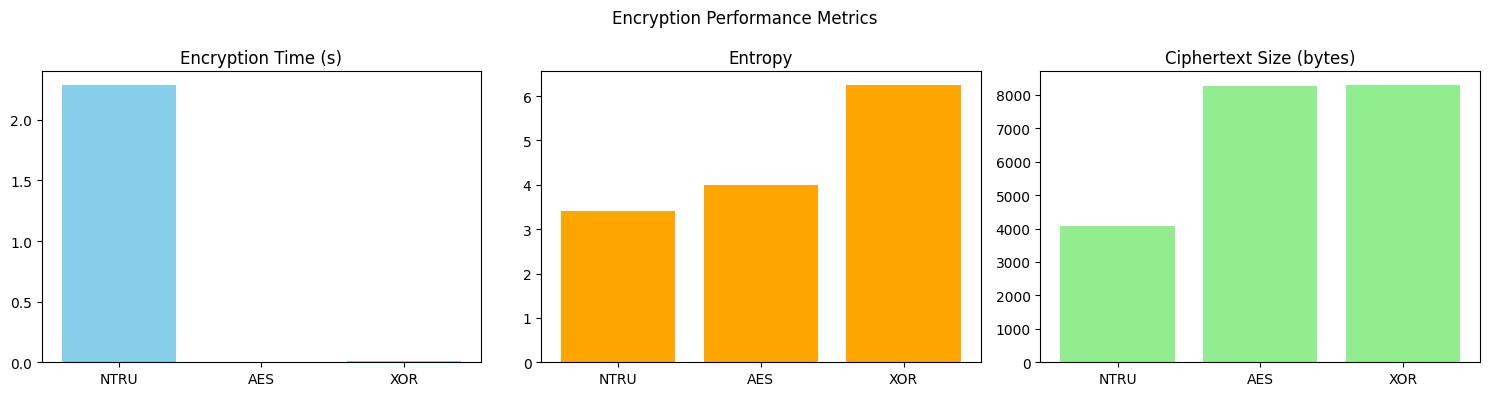

ntru_time: 2.2855584621429443
ntru_ciphertext_size: 4073
ntru_hamming: 129
ntru_entropy: 3.4030305188401866
aes_time: 0.00043082237243652344
aes_ciphertext_size: 8269
aes_hamming: 119
aes_entropy: 4.001546651688996
xor_time: 0.011223554611206055
xor_ciphertext_size: 8286
xor_hamming: 134
xor_entropy: 6.245636770175842
final_encoded_size: 6508
encryption_time: 2.297212839126587
decryption_time: 3.961142063140869
ciphertext_size: 8286
encryption_throughput: 31.34232874450362
decryption_throughput: 18.176576061225575
decrypted_message: This is a test message and will be used to calculate evaluation metrics.


In [33]:
metrics = evaluate_encryption_system("This is a test message and will be used to calculate evaluation metrics.")
for k, v in metrics.items():
    print(f"{k}: {v}")

🔹 MSE: 0.0009
🔹 PSNR: 78.75 dB
🔹 SSIM: 1.0000
🔹 Entropy Difference: 0.0000
🔍 Chi-Square Statistic: 0.00
✅ No significant steganographic modifications detected.
🔍 Histogram Difference Score: 0.0369
⚠️ Small variations detected – Might be minor modifications.


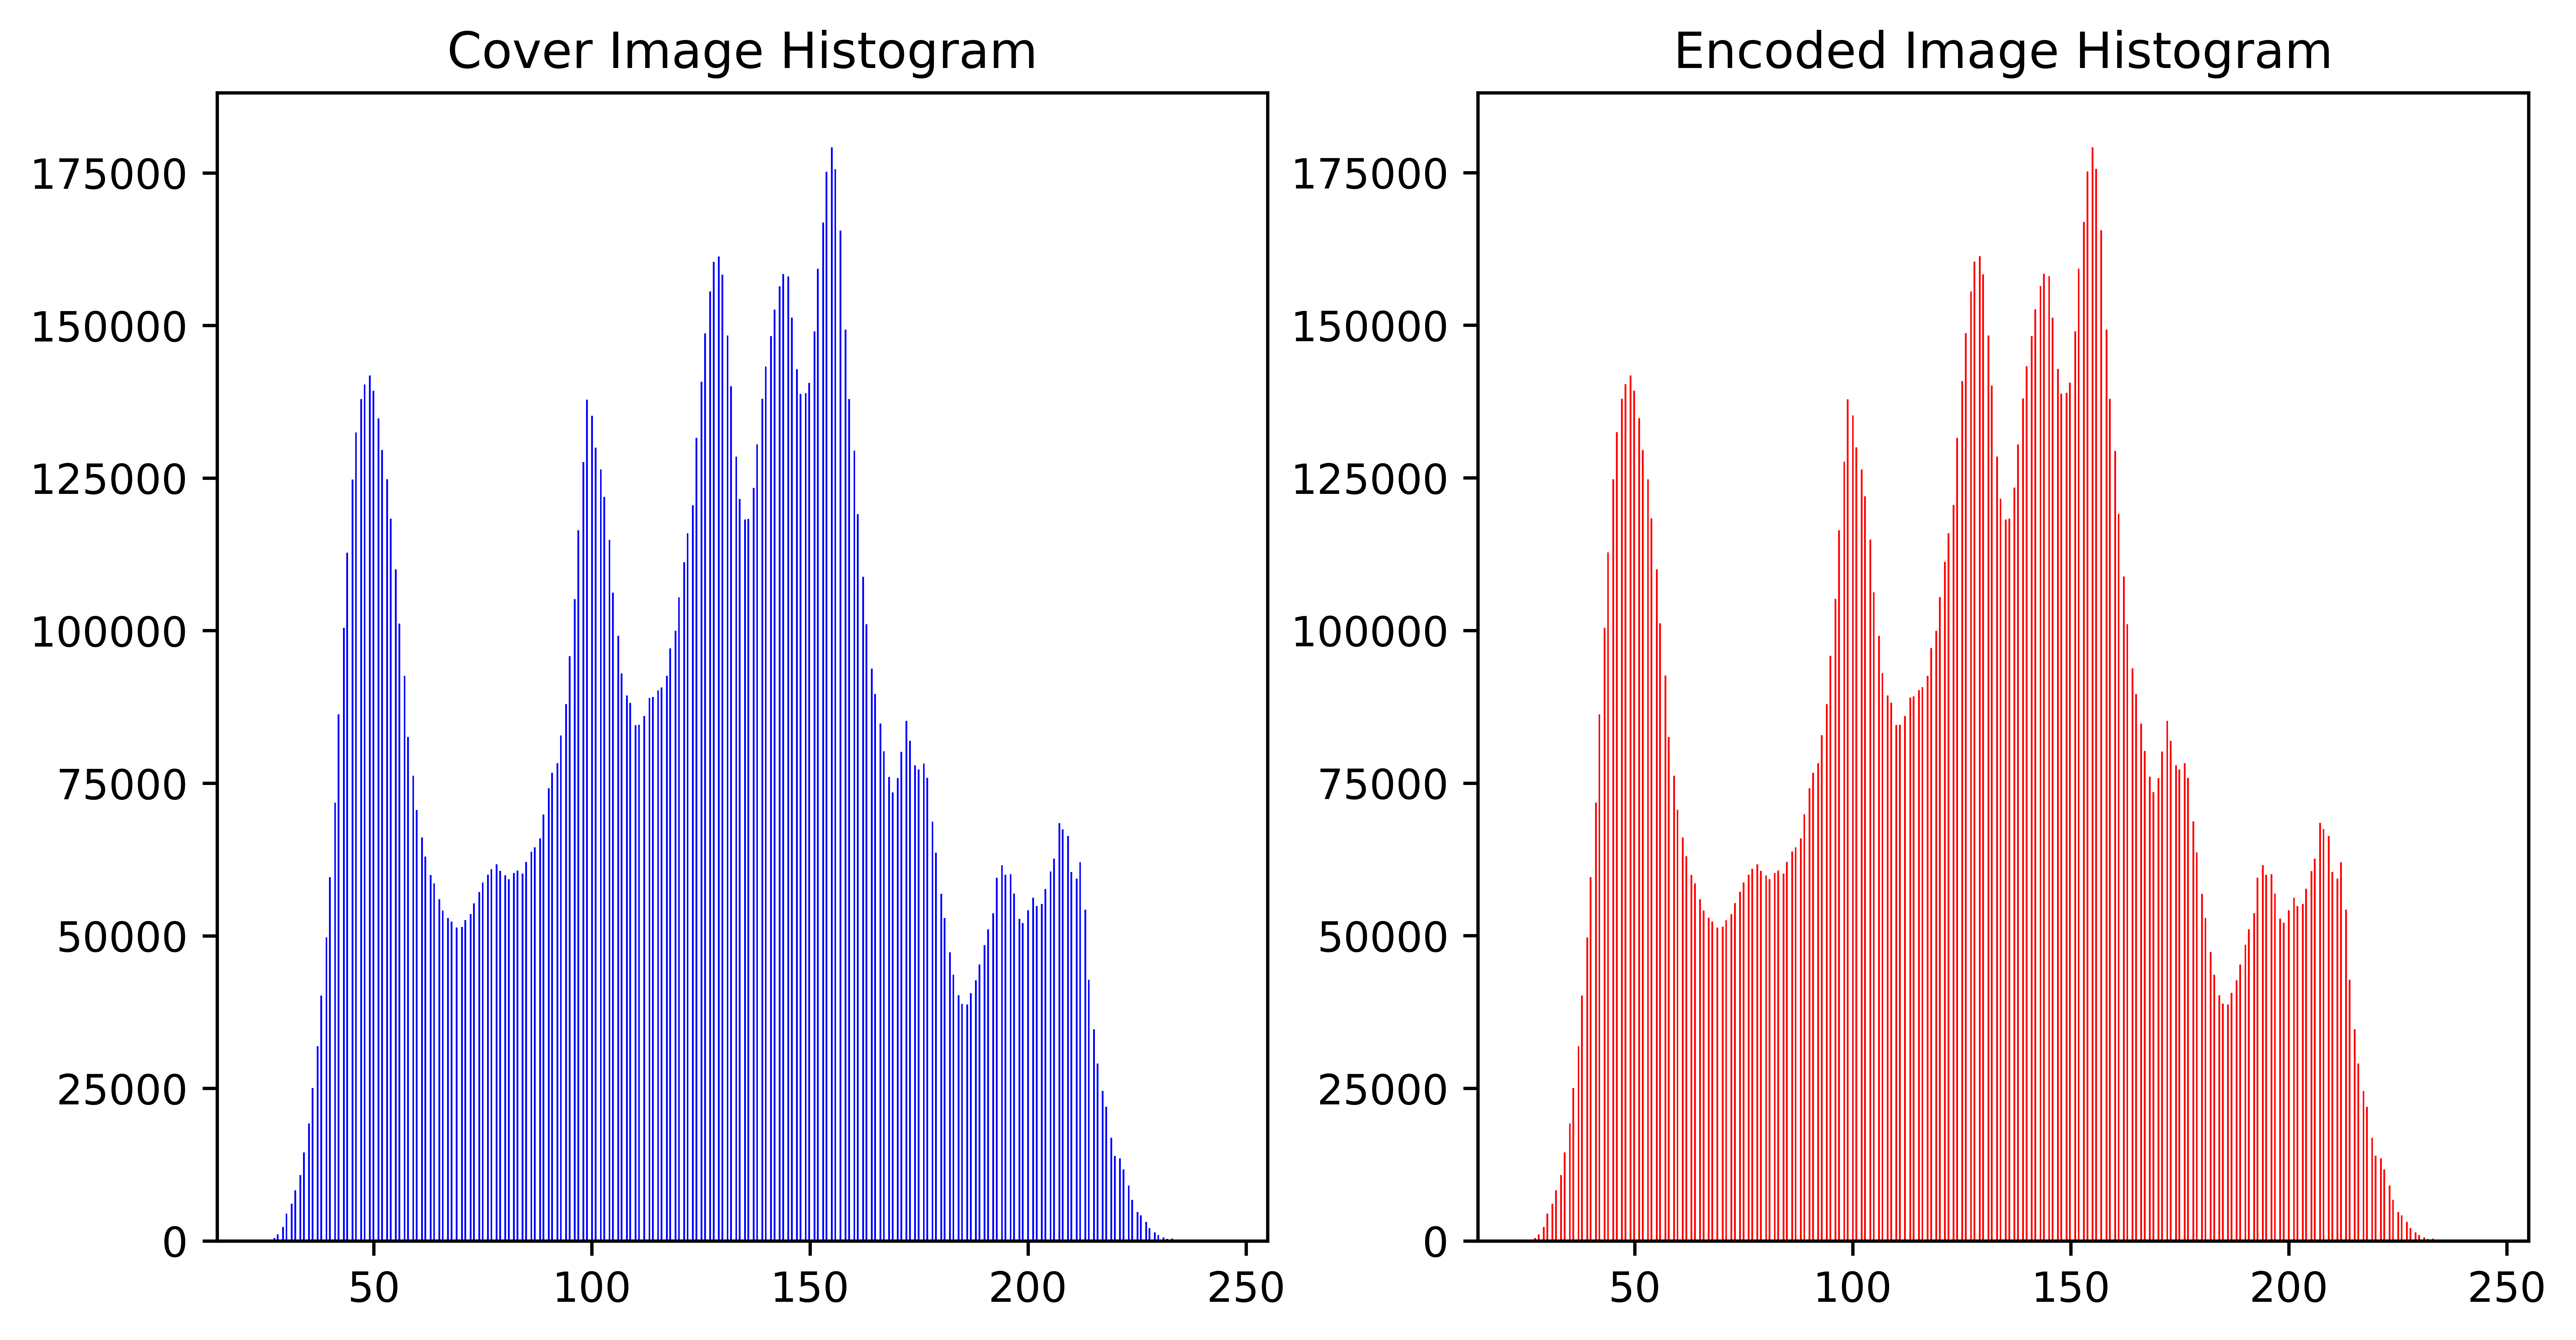

In [36]:

# Load original and encoded images
original_img = cv2.imread("project_dir/lena2.png")
encoded_img = cv2.imread("/teamspace/studios/this_studio/project_dir/stego (1).png")

# Convert to RGB for display
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
encoded_img = cv2.cvtColor(encoded_img, cv2.COLOR_BGR2RGB)


import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy

def calculate_metrics(original, stego):
    # Convert images to grayscale for better comparison
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    stego_gray = cv2.cvtColor(stego, cv2.COLOR_BGR2GRAY)

    # Compute MSE
    mse_value = np.mean((original_gray - stego_gray) ** 2)

    # Compute PSNR
    psnr_value = psnr(original_gray, stego_gray, data_range=255)

    # Compute SSIM
    ssim_value, _ = ssim(original_gray, stego_gray, full=True)

    # Compute Entropy Difference
    entropy_original = entropy(np.histogram(original_gray, bins=256, range=(0, 255))[0])
    entropy_stego = entropy(np.histogram(stego_gray, bins=256, range=(0, 255))[0])
    entropy_diff = abs(entropy_original - entropy_stego)

    print(f"🔹 MSE: {mse_value:.4f}")
    print(f"🔹 PSNR: {psnr_value:.2f} dB")
    print(f"🔹 SSIM: {ssim_value:.4f}")
    print(f"🔹 Entropy Difference: {entropy_diff:.4f}")

    # return mse_value, psnr_value, ssim_value, entropy_diff
    return None

# Compute metrics
calculate_metrics(original_img, encoded_img)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.fftpack import fft2, fftshift

def chi_square_test(original_gray, stego_gray):
    """Performs a chi-square test on histograms to detect steganographic modifications."""
    hist_original = np.histogram(original_gray, bins=256, range=(0, 255))[0]
    hist_stego = np.histogram(stego_gray, bins=256, range=(0, 255))[0]

    # Normalize histograms to ensure they have the same total sum
    hist_original = hist_original / hist_original.sum()
    hist_stego = hist_stego / hist_stego.sum()

    # Add a small value to avoid division by zero
    hist_original += 1e-8
    hist_stego += 1e-8

    chi_square_stat, _ = chisquare(hist_stego, f_exp=hist_original)
    
    # Interpretation of Chi-Square value
    print(f"🔍 Chi-Square Statistic: {chi_square_stat:.2f}")
    if chi_square_stat < 50:
        print("✅ No significant steganographic modifications detected.")
    elif 50 <= chi_square_stat < 200:
        print("⚠️ Possible slight embedding detected, further analysis recommended.")
    else:
        print("❌ High deviation detected – Strong evidence of steganographic content!")
    
    return chi_square_stat

def high_frequency_analysis(original_gray, stego_gray):
    """Computes high-frequency noise difference using Fourier transform."""
    fft_orig = np.abs(fftshift(fft2(original_gray)))
    fft_stego = np.abs(fftshift(fft2(stego_gray)))

    noise_level = np.mean(np.abs(fft_stego - fft_orig))

    # Interpretation of noise level
    print(f"🔍 High-Frequency Noise Level: {noise_level:.4f}")
    if noise_level < 0.005:
        print("✅ No significant noise detected – Image likely unaltered.")
    elif 0.005 <= noise_level < 0.02:
        print("⚠️ Minor high-frequency noise detected – Possible modifications.")
    else:
        print("❌ Significant noise detected – Strong evidence of steganographic embedding!")
    
    return noise_level

def histogram_analysis(original_gray, stego_gray):

    """Plots histograms of pixel intensity distributions."""
    # Compute histogram difference
    hist_diff = np.sum(np.abs(original_gray - stego_gray)) / original_gray.size
    print(f"🔍 Histogram Difference Score: {hist_diff:.4f}")
    if hist_diff < 0.01:
        print("✅ Almost identical histograms – No noticeable steganography.")
    elif 0.01 <= hist_diff < 0.05:
        print("⚠️ Small variations detected – Might be minor modifications.")
    elif 0.05 <= hist_diff < 0.15:
        print("❗ Noticeable differences – Possible hidden data.")
    else:
        print("❌ Strong histogram shift – Likely steganographic content detected!")

    plt.figure(figsize=(10, 5), dpi = 1000)
    bins = 550
    
    plt.subplot(1, 2, 1)
    plt.hist(original_gray.ravel(), bins, color='blue', alpha=1)
    plt.title("Cover Image Histogram")
    
    plt.subplot(1, 2, 2)
    plt.hist(stego_gray.ravel(), bins, color='red', alpha=1)
    plt.title("Encoded Image Histogram")
    
    plt.show()

    
# Load and preprocess images
original_img = cv2.imread("lena2.png")
encoded_img = cv2.imread("/teamspace/studios/this_studio/DCT_STEG_IMG_crazy.png")

if original_img is None or encoded_img is None:
    print("⚠️ Error: One or both images could not be loaded. Check file paths.")
else:
    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    stego_gray = cv2.cvtColor(encoded_img, cv2.COLOR_BGR2GRAY)

    # Compute steganalysis metrics
    chi_square_value = chi_square_test(original_gray, stego_gray)
    # noise_level = high_frequency_analysis(original_gray, stego_gray)

    # Histogram Analysis
    histogram_analysis(original_gray, stego_gray)

